In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy.stats import ttest_rel
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# get raw data frame from csv
raw_data = pd.read_csv('/Users/erinburns/Library/CloudStorage/Box-Box/CoganLab/D_Data/GlobalLocal/combinedData.csv')

In [28]:
# add columns for previous trial accuracy and previous trial type
raw_data['prev_acc'] = raw_data.groupby('subject_ID')['acc'].shift(1)
raw_data['prev_cong'] = raw_data.groupby('subject_ID')['congruency'].shift(1)
raw_data['prev_sw'] = raw_data.groupby('subject_ID')['switchType'].shift(1)
raw_data['is_post_error'] = raw_data['prev_acc'] == 0

# removing subjects with low error counts from raw_data
error_counts = raw_data.groupby('subject_ID')['is_post_error'].sum()
subjects_to_remove = error_counts[error_counts < 25].index
raw_data = raw_data[~raw_data['subject_ID'].isin(subjects_to_remove)]

df = raw_data.copy()

In [22]:
# set up dictionaries
post_iR_error_inc_correct = {
    'post_error': True,   
    'prev_cong': 'i',     
    'prev_sw': 'r',       
    'curr_cong': 'i',     
    'current_acc': 1      
}
post_iR_error_switch_correct = {
    'post_error': True,   
    'prev_cong': 'i',     
    'prev_sw': 'r',       
    'curr_sw': 's',     
    'current_acc': 1      
}
post_cS_error_switch_correct = {
    'post_error': True,   
    'prev_cong': 'c',     
    'prev_sw': 's',       
    'curr_sw': 's',     
    'current_acc': 1      
}
post_cS_error_inc_correct = {
    'post_error': True,   
    'prev_cong': 'c',     
    'prev_sw': 's',       
    'curr_cong': 'i',     
    'current_acc': 1      
}

#correct dictionaries
post_iR_corr_inc_correct = {
    'post_error': False,   
    'prev_cong': 'i',     
    'prev_sw': 'r',       
    'curr_cong': 'i',     
    'current_acc': 1      
}
post_iR_corr_switch_correct = {
    'post_error': False,   
    'prev_cong': 'i',     
    'prev_sw': 'r',       
    'curr_sw': 's',     
    'current_acc': 1      
}
post_cS_corr_switch_correct = {
    'post_error': False,   
    'prev_cong': 'c',     
    'prev_sw': 's',       
    'curr_sw': 's',     
    'current_acc': 1      
}
post_cS_corr_inc_correct = {
    'post_error': False,   
    'prev_cong': 'c',     
    'prev_sw': 's',       
    'curr_cong': 'i',     
    'current_acc': 1      
}

In [23]:
def get_subject_means(df, post_error=None, prev_cong=None, prev_sw=None, curr_cong=None, curr_sw=None, current_acc=1):
    """
    Filters data and returns mean RT per subject.
    post_error: True (post-error), False (post-correct), or None (both)
    prev_cong: 'i', 'c'
    prev_sw: 'r', 's', or None 
    curr_cong: 'i', 'c'
    curr_sw: 'r', 's', or None 
    current_acc: 1 (correct), 0 (incorrect)
    """
    mask = (df['RT'] > 0) # Base mask
    
    if post_error is not None:
        mask &= (df['is_post_error'] == post_error)
    if prev_cong is not None:
        mask &= (df['prev_cong'] == prev_cong)
    if prev_sw is not None:
        mask &= (df['prev_sw'] == prev_sw)
    if current_acc is not None:
        mask &= (df['acc'] == current_acc)

    if curr_cong is not None:
        mask &= (df['congruency'] == curr_cong)
    if curr_sw is not None:
        mask &= (df['switchType'] == curr_sw)
    if current_acc is not None:
        mask &= (df['acc'] == current_acc)
        
    # Group by subject and calculate mean + trial count
    stats = df[mask].groupby('subject_ID')['RT'].agg(['mean', 'count'])
    return stats

In [24]:
def run_comparison(df, label1, label2, params1, params2):
    """
    params1 and params2 are dictionaries of the manual inputs we discussed.
    Example: params1 = {'post_error': True, 'curr_cong': 'i'}
    """
    # subject mean for both conditions
    res1 = get_subject_means(df, **params1)
    res2 = get_subject_means(df, **params2)
    
    # compare same subject
    comparison_df = pd.merge(res1, res2, on='subject_ID', suffixes=('_1', '_2'))

    final = comparison_df.dropna()
    
    # t-test
    t_stat, p_val = stats.ttest_rel(final['mean_1'], final['mean_2'])
    
    # print
    print(f"Comparison: {label1} vs {label2}")
    print(f"N Subjects: {len(final)}")
    print(f"Mean {label1}: {final['mean_1'].mean():.2f} ms")
    print(f"Mean {label2}: {final['mean_2'].mean():.2f} ms")
    print(f"t({len(final)-1}) = {t_stat:.3f}, p = {p_val:.4f}")
    
    return final

In [29]:
# run 
results1 = run_comparison(df, "post_iR_error_inc_correct", "post_iR_error_switch_correct", post_iR_error_inc_correct, post_iR_error_switch_correct)
results2 = run_comparison(df, "post_cS_error_inc_correct", "post_cS_error_switch_correct", post_cS_error_inc_correct, post_cS_error_switch_correct)
results3 = run_comparison(df, "post_iR_corr_inc_correct", "post_iR_corr_switch_correct", post_iR_corr_inc_correct, post_iR_corr_switch_correct)
results4 = run_comparison(df, "post_cS_corr_inc_correct", "post_cS_corr_switch_correct", post_cS_corr_inc_correct, post_cS_corr_switch_correct)

Comparison: post_iR_error_inc_correct vs post_iR_error_switch_correct
N Subjects: 18
Mean post_iR_error_inc_correct: 1374.84 ms
Mean post_iR_error_switch_correct: 1466.89 ms
t(17) = -2.172, p = 0.0443
Comparison: post_cS_error_inc_correct vs post_cS_error_switch_correct
N Subjects: 16
Mean post_cS_error_inc_correct: 1600.17 ms
Mean post_cS_error_switch_correct: 1517.64 ms
t(15) = 1.518, p = 0.1497
Comparison: post_iR_corr_inc_correct vs post_iR_corr_switch_correct
N Subjects: 19
Mean post_iR_corr_inc_correct: 1239.70 ms
Mean post_iR_corr_switch_correct: 1320.86 ms
t(18) = -4.693, p = 0.0002
Comparison: post_cS_corr_inc_correct vs post_cS_corr_switch_correct
N Subjects: 19
Mean post_cS_corr_inc_correct: 1439.57 ms
Mean post_cS_corr_switch_correct: 1317.05 ms
t(18) = 3.050, p = 0.0069


In [30]:
# plotting code

def plot_results(results_df, label1, label2, title):
    fig, ax = plt.subplots(figsize=(6, 8))

    # 1. Individual Subject Lines
    for i in results_df.index:
        ax.plot([0, 1], [results_df.loc[i, 'mean_1'], results_df.loc[i, 'mean_2']], 
                color='gray', alpha=0.3, linewidth=1.5, zorder=1)

    # 2. Individual Data Points
    ax.scatter([0]*len(results_df), results_df['mean_1'], color='tab:blue', s=120, alpha=0.6, zorder=2)
    ax.scatter([1]*len(results_df), results_df['mean_2'], color='tab:red', s=120, alpha=0.6, zorder=2)

    # 3. Group Mean + SEM
    means = [results_df['mean_1'].mean(), results_df['mean_2'].mean()]
    sems = [results_df['mean_1'].sem(), results_df['mean_2'].sem()]
    
    ax.errorbar([0, 1], means, yerr=sems, fmt='o-', color='black', 
                linewidth=5, markersize=16, capsize=12, zorder=3)

    # 4. Statistical Annotation
    t_stat, p_val = stats.ttest_rel(results_df['mean_1'], results_df['mean_2'])
    y_max = results_df[['mean_1', 'mean_2']].max().max()
    ax.text(0.5, y_max * 1.05, f"p = {p_val:.4f}", ha='center', fontweight='bold', fontsize=14)

    # 5. Styling
    ax.set_xticks([0, 1])
    ax.set_xticklabels([label1, label2], fontweight='bold', fontsize=14)
    ax.set_ylabel('Reaction Time (ms)', fontweight='bold', fontsize=14)
    ax.set_title(title, pad=30, fontweight='bold', fontsize=16)
    ax.set_xlim(-0.5, 1.5)
    
    # Simple Spine removal
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

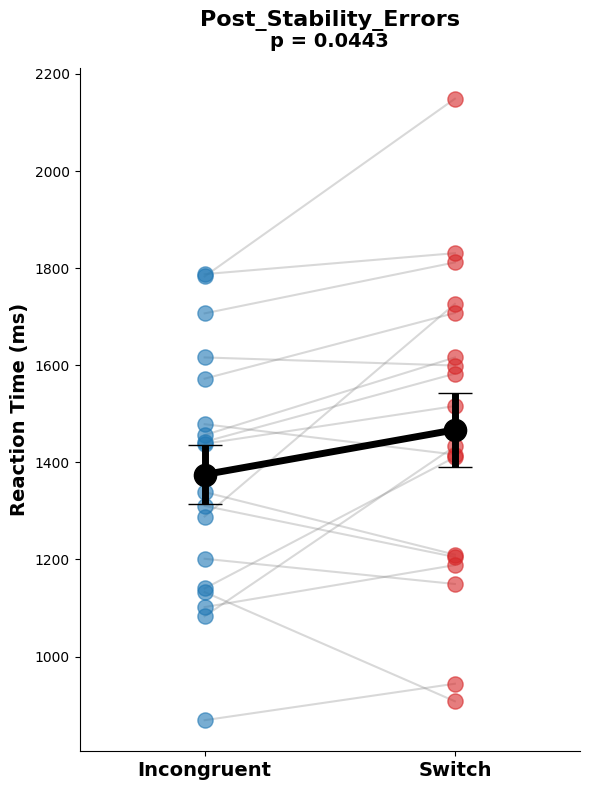

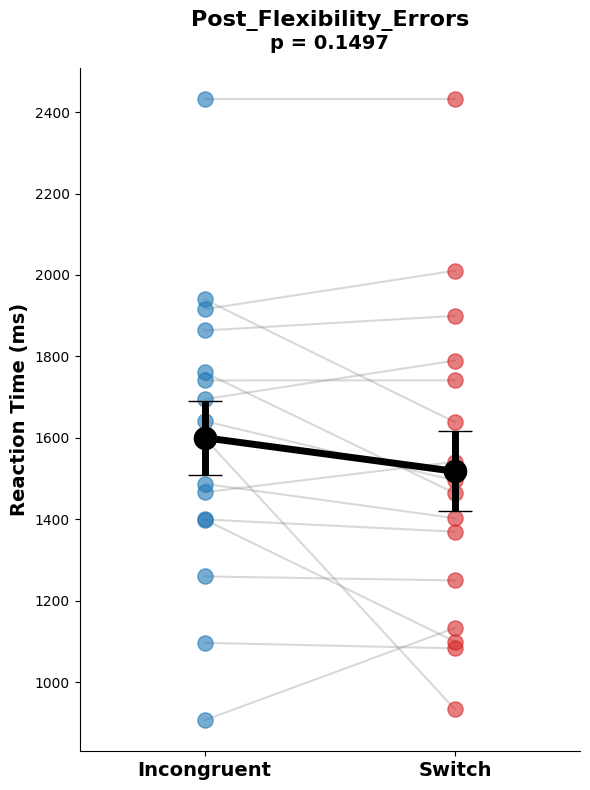

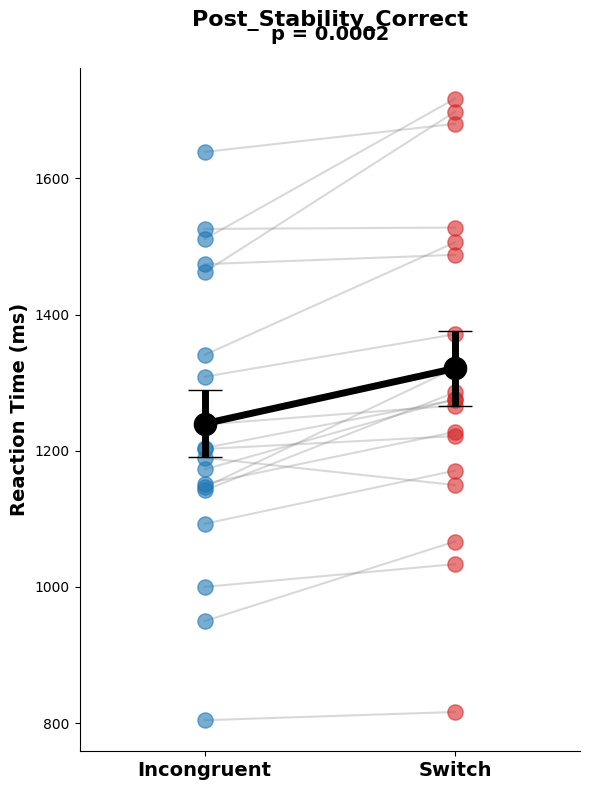

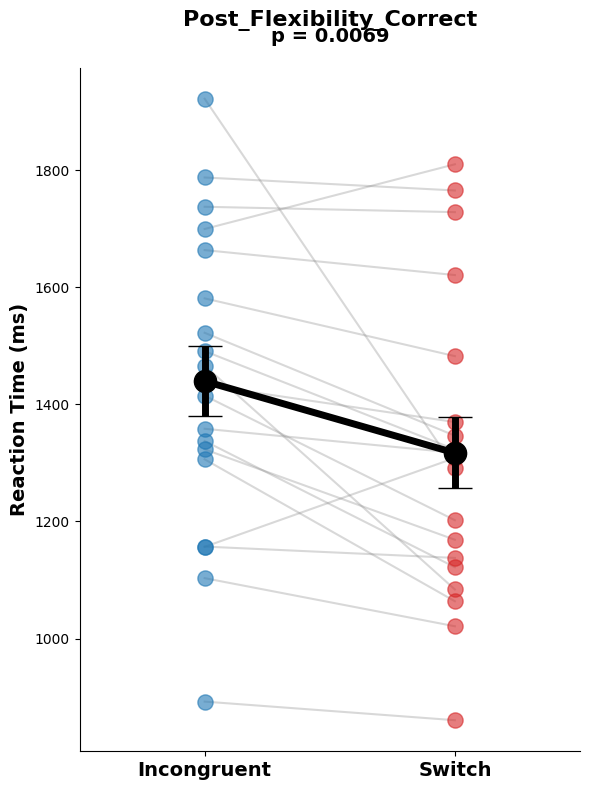

In [31]:
plot_results(results1, "Incongruent", "Switch", "Post_Stability_Errors")
plot_results(results2, "Incongruent", "Switch", "Post_Flexibility_Errors")
plot_results(results3, "Incongruent", "Switch", "Post_Stability_Correct")
plot_results(results4, "Incongruent", "Switch", "Post_Flexibility_Correct")